In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_curve

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv("iot23_final_preprocessed.csv")

In [19]:
df.head()

,Unnamed: 0,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,label,proto_tcp,proto_udp,conn_state_REJ,...,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR,service_dhcp,service_dns,service_http,service_irc,service_ssh,service_ssl
0,20,0.000061,0.0,0.0,3.0,0.0,PartOfAHorizontalPortScan,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0.000000,0.0,0.0,1.0,0.0,PartOfAHorizontalPortScan,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,0.000061,0.0,0.0,3.0,0.0,PartOfAHorizontalPortScan,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,0.000000,0.0,0.0,1.0,0.0,PartOfAHorizontalPortScan,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27,0.000000,0.0,0.0,1.0,0.0,Benign,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:


print(df.columns)

Index(['Unnamed: 0', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts',
       'resp_pkts', 'label', 'proto_tcp', 'proto_udp', 'conn_state_REJ',
       'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR',
       'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2',
       'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR',
       'service_dhcp', 'service_dns', 'service_http', 'service_irc',
       'service_ssh', 'service_ssl'],
      dtype='object')


In [21]:
df['label'].unique()

array(['PartOfAHorizontalPortScan', 'Benign', 'Okiru', 'DDoS',
       'C&C-HeartBeat', 'C&C', 'Attack'], dtype=object)

In [22]:
df['label'].value_counts()

label
PartOfAHorizontalPortScan    825417
Okiru                        262503
Benign                       197274
DDoS                         138718
C&C                           15003
Attack                         3914
C&C-HeartBeat                   308
Name: count, dtype: int64

In [23]:
# Directly convert to binary before doing any ML
df['label'] = df['label'].apply(lambda x: 0 if x == 'Benign' else 1)


In [24]:
y = df['label']
X=df = df.drop(columns=['label', 'Unnamed: 0'])
selected_indexes = [0, 3,6,5,1]  # example column indexes
X = X.iloc[:, selected_indexes]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=69, stratify=y
)


In [25]:
print(X_train)

             duration  orig_pkts  proto_udp  proto_tcp  orig_bytes
1367863  0.000000e+00        1.0        0.0        1.0         0.0
1158481  0.000000e+00        0.0        0.0        1.0         0.0
130757   4.083565e-11        2.0        0.0        1.0         0.0
596789   0.000000e+00        1.0        0.0        1.0         0.0
33774    0.000000e+00        1.0        0.0        1.0         0.0
...               ...        ...        ...        ...         ...
1147044  0.000000e+00        0.0        0.0        1.0         0.0
1026102  1.020891e-10        2.0        0.0        1.0         0.0
862968   6.326485e-05        6.0        0.0        1.0         0.0
1347712  0.000000e+00        1.0        0.0        1.0         0.0
465231   6.374377e-05        3.0        0.0        1.0         0.0

[1082352 rows x 5 columns]


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [53]:
len(X_train)

1082352

In [57]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import sys

# Function to calculate model size in KB
def get_model_size(model):
    if isinstance(model, nn.Module):
        # PyTorch model size calculation
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        size_kb = (param_size + buffer_size) / 1024
        return size_kb
    elif isinstance(model, xgb.Booster):
        # XGBoost model size calculation (approximate)
        return sys.getsizeof(model) / 1024
    else:
        # For scikit-learn models
        return sys.getsizeof(model) / 1024

# Neural Network model definition (as provided)
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Output: 2 classes for binary classification
        )
    def forward(self, x):
        return self.network(x)

# Function to get soft probabilities from the models
def get_soft_probabilities(model, X, model_type):
    if model_type == 'nn':
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            logits = model(X_tensor)
            return torch.softmax(logits, dim=1).numpy()
    elif model_type == 'xgb':
        X_dmatrix = xgb.DMatrix(X)
        # Get raw scores
        raw_scores = model.predict(X_dmatrix, output_margin=True)
        # Convert to probabilities
        if raw_scores.ndim == 1:
            # Binary classification
            probs = 1 / (1 + np.exp(-raw_scores))
            return np.column_stack((1 - probs, probs))
        else:
            # Multiclass
            exp_scores = np.exp(raw_scores)
            return exp_scores / exp_scores.sum(axis=1, keepdims=True)
    elif model_type == 'nb':
        return model.predict_proba(X)
    else:
        raise ValueError("Unknown model type")

# Function to count parameters for Naive Bayes
def count_nb_params(nb_model):
    # GaussianNB parameters
    params_count = 0
    if hasattr(nb_model, 'theta_'):
        params_count += nb_model.theta_.size
    if hasattr(nb_model, 'var_'):  # GaussianNB uses var_ not sigma_
        params_count += nb_model.var_.size
    if hasattr(nb_model, 'class_prior_'):
        params_count += nb_model.class_prior_.size
    if hasattr(nb_model, 'class_count_'):
        params_count += nb_model.class_count_.size
    
    return params_count

# Main function for training and distillation
def knowledge_distillation():
    # Assume X and y are already available in your environment
    # If X and y are pandas DataFrame/Series, convert them to numpy arrays
    
    # Check if X and y exist in the global namespace
    try:
        # Get X and y from global namespace
        global X, y
        
        # Convert to numpy arrays if they are pandas objects
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
    except NameError:
        # If X and y don't exist, create dummy data for demonstration
        print("X and y not found in global namespace. Creating dummy data...")
        np.random.seed(42)
        X = np.random.rand(1000, 20)  # 1000 samples, 20 features
        y = np.random.randint(0, 2, 1000)  # Binary classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to numpy arrays (ensure they're not pandas objects)
    if isinstance(X_train_scaled, pd.DataFrame):
        X_train_scaled = X_train_scaled.values
    if isinstance(X_test_scaled, pd.DataFrame):
        X_test_scaled = X_test_scaled.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
        
    # Convert to PyTorch tensors for the neural network
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create DataLoaders for training the neural network
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Model 1: Neural Network
    print("Training Neural Network...")
    input_size = X_train.shape[1]
    nn_model = SimpleNN(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
    
    # Train the neural network
    nn_model.train()
    for epoch in range(50):  # 10 epochs for demonstration
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate NN model
    nn_model.eval()
    with torch.no_grad():
        y_pred_nn = torch.argmax(nn_model(X_test_tensor), dim=1).numpy()
        nn_accuracy = accuracy_score(y_test, y_pred_nn)
        nn_probs = torch.softmax(nn_model(X_test_tensor), dim=1).numpy()
    
    # Model 2: XGBoost
    print("Training XGBoost...")
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'eta': 0.3,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    # Evaluate XGBoost model
    y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_probs = get_soft_probabilities(xgb_model, X_test_scaled, 'xgb')
    
    # Model 3: Naive Bayes
    print("Training Naive Bayes...")
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    
    # Evaluate Naive Bayes model
    y_pred_nb = nb_model.predict(X_test_scaled)
    nb_accuracy = accuracy_score(y_test, y_pred_nb)
    nb_probs = nb_model.predict_proba(X_test_scaled)
    
    # Ensemble the soft predictions from the teacher models
    # We'll use a simple average of probabilities
    teacher_probs = (nn_probs + xgb_probs + nb_probs) / 3
    
    # Now we'll distill this knowledge into simpler models
    
    # Model 4: Logistic Regression (distilled)
    print("Training Logistic Regression with distilled knowledge...")
    # Use soft targets for training
    sample_weights = compute_sample_weight('balanced', y_train)
    lr_model = LogisticRegression(max_iter=1000, C=1.0)
    
    # Instead of fitting to hard labels, we fit to the teacher's probability predictions
    # For this we generate predictions on the training set
    nn_model.eval()
    with torch.no_grad():
        nn_train_probs = torch.softmax(nn_model(X_train_tensor), dim=1).numpy()
    
    xgb_train_probs = get_soft_probabilities(xgb_model, X_train_scaled, 'xgb')
    nb_train_probs = nb_model.predict_proba(X_train_scaled)
    
    # Average the probabilities
    teacher_train_probs = (nn_train_probs + xgb_train_probs + nb_train_probs) / 3
    
    # For logistic regression, we'll use the teacher's predicted class but with sample weights
    # based on the probability
    teacher_train_preds = np.argmax(teacher_train_probs, axis=1)
    
    # Train logistic regression on teacher predictions
    lr_model.fit(X_train_scaled, teacher_train_preds, sample_weight=sample_weights)
    
    # Evaluate distilled logistic regression
    y_pred_lr = lr_model.predict(X_test_scaled)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_probs = lr_model.predict_proba(X_test_scaled)
    
    # Model 5: Decision Tree (distilled)
    print("Training Decision Tree with distilled knowledge...")
    dt_model = DecisionTreeClassifier(max_depth=5)
    
    # Train the decision tree using soft labels
    # We'll use the predicted class but with weights based on probability
    dt_model.fit(X_train_scaled, teacher_train_preds, sample_weight=sample_weights)
    
    # Evaluate distilled decision tree
    y_pred_dt = dt_model.predict(X_test_scaled)
    dt_accuracy = accuracy_score(y_test, y_pred_dt)
    dt_probs = dt_model.predict_proba(X_test_scaled)
    
    # Calculate model sizes
    nn_size = get_model_size(nn_model)
    xgb_size = get_model_size(xgb_model)
    nb_size = get_model_size(nb_model)
    lr_size = get_model_size(lr_model)
    dt_size = get_model_size(dt_model)
    
    # Parameter counts (approximate)
    nn_params = sum(p.numel() for p in nn_model.parameters())
    
    # Fixed XGBoost parameter counting
    try:
        xgb_feature_count = len(xgb_model.get_score(importance_type='weight'))
    except:
        # Fallback if get_score() fails
        xgb_feature_count = X_train.shape[1]
    
    # Fixed Naive Bayes parameter counting
    nb_params = count_nb_params(nb_model)
    
    lr_params = np.prod(lr_model.coef_.shape) + lr_model.intercept_.shape[0]
    dt_params = dt_model.tree_.node_count * 4  # Approximate: each node has feature, threshold, and 2 children
    
    # Print results
    print("\n===== MODEL COMPARISON =====")
    print(f"Neural Network - Size: {nn_size:.2f} KB, Params: {nn_params}, Accuracy: {nn_accuracy:.4f}")
    print(f"XGBoost - Size: {xgb_size:.2f} KB, Features: {xgb_feature_count}, Accuracy: {xgb_accuracy:.4f}")
    print(f"Naive Bayes - Size: {nb_size:.2f} KB, Params: {nb_params}, Accuracy: {nb_accuracy:.4f}")
    print(f"Logistic Regression (Distilled) - Size: {lr_size:.2f} KB, Params: {lr_params}, Accuracy: {lr_accuracy:.4f}")
    print(f"Decision Tree (Distilled) - Size: {dt_size:.2f} KB, Params: {dt_params}, Accuracy: {dt_accuracy:.4f}")
    
    # Calculate size reduction
    complex_avg_size = (nn_size + xgb_size + nb_size) / 3
    simple_avg_size = (lr_size + dt_size) / 2
    size_reduction = (complex_avg_size - simple_avg_size) / complex_avg_size * 100
    
    # Calculate accuracy retention
    complex_avg_acc = (nn_accuracy + xgb_accuracy + nb_accuracy) / 3
    simple_avg_acc = (lr_accuracy + dt_accuracy) / 2
    accuracy_retention = simple_avg_acc / complex_avg_acc * 100
    
    print(f"\nSize Reduction: {size_reduction:.2f}%")
    print(f"Accuracy Retention: {accuracy_retention:.2f}%")
    
    # Plot model comparison
    models = ['Neural Network', 'XGBoost', 'Naive Bayes', 'Logistic Regression', 'Decision Tree']
    sizes = [nn_size, xgb_size, nb_size, lr_size, dt_size]
    accuracies = [nn_accuracy, xgb_accuracy, nb_accuracy, lr_accuracy, dt_accuracy]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.bar(models, sizes)
    ax1.set_title('Model Size Comparison (KB)')
    ax1.set_ylabel('Size (KB)')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(models, accuracies)
    ax2.set_title('Accuracy Comparison')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()
    
    # Return the models and metrics
    return {
        'complex_models': {
            'nn': nn_model,
            'xgb': xgb_model,
            'nb': nb_model
        },
        'distilled_models': {
            'lr': lr_model,
            'dt': dt_model
        },
        'metrics': {
            'nn_accuracy': nn_accuracy,
            'xgb_accuracy': xgb_accuracy,
            'nb_accuracy': nb_accuracy,
            'lr_accuracy': lr_accuracy,
            'dt_accuracy': dt_accuracy,
            'size_reduction': size_reduction,
            'accuracy_retention': accuracy_retention
        }
    }

# Run the distillation process
if __name__ == "__main__":
    start_time = time.time()
    results = knowledge_distillation()
    end_time = time.time()
    
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
    
    # You can access the models and metrics from the results dictionary
    # Example: lr_model = results['distilled_models']['lr']

Training Neural Network...
Training XGBoost...
Training Naive Bayes...
Training Logistic Regression with distilled knowledge...
Training Decision Tree with distilled knowledge...

===== MODEL COMPARISON =====
Neural Network - Size: 174.28 KB, Params: 43714, Accuracy: 0.9030
XGBoost - Size: 0.05 KB, Features: 5, Accuracy: 0.9352
Naive Bayes - Size: 0.05 KB, Params: 24, Accuracy: 0.9033
Logistic Regression (Distilled) - Size: 0.05 KB, Params: 6, Accuracy: 0.9033
Decision Tree (Distilled) - Size: 0.05 KB, Params: 60, Accuracy: 0.9033

Size Reduction: 99.92%
Accuracy Retention: 98.85%

Total execution time: 2323.09 seconds


In [59]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import sys

# Function to calculate model size in KB
def get_model_size(model):
    if isinstance(model, nn.Module):
        # PyTorch model size calculation
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        size_kb = (param_size + buffer_size) / 1024
        return size_kb
    elif isinstance(model, xgb.Booster):
        # XGBoost model size calculation (approximate)
        return sys.getsizeof(model) / 1024
    else:
        # For scikit-learn models
        return sys.getsizeof(model) / 1024

# Neural Network model definition (as provided)
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Output: 2 classes for binary classification
        )
    def forward(self, x):
        return self.network(x)

# Function to get soft probabilities from the models
def get_soft_probabilities(model, X, model_type):
    if model_type == 'nn':
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            logits = model(X_tensor)
            return torch.softmax(logits, dim=1).numpy()
    elif model_type == 'xgb':
        X_dmatrix = xgb.DMatrix(X)
        # Get raw scores
        raw_scores = model.predict(X_dmatrix, output_margin=True)
        # Convert to probabilities
        if raw_scores.ndim == 1:
            # Binary classification
            probs = 1 / (1 + np.exp(-raw_scores))
            return np.column_stack((1 - probs, probs))
        else:
            # Multiclass
            exp_scores = np.exp(raw_scores)
            return exp_scores / exp_scores.sum(axis=1, keepdims=True)
    elif model_type == 'nb':
        return model.predict_proba(X)
    else:
        raise ValueError("Unknown model type")

# Function to count parameters for Naive Bayes
def count_nb_params(nb_model):
    # GaussianNB parameters
    params_count = 0
    if hasattr(nb_model, 'theta_'):
        params_count += nb_model.theta_.size
    if hasattr(nb_model, 'var_'):  # GaussianNB uses var_ not sigma_
        params_count += nb_model.var_.size
    if hasattr(nb_model, 'class_prior_'):
        params_count += nb_model.class_prior_.size
    if hasattr(nb_model, 'class_count_'):
        params_count += nb_model.class_count_.size
    
    return params_count

# Main function for training and distillation
def knowledge_distillation():
    # Assume X and y are already available in your environment
    # If X and y are pandas DataFrame/Series, convert them to numpy arrays
    
    # Check if X and y exist in the global namespace
    try:
        # Get X and y from global namespace
        global X, y
        
        # Convert to numpy arrays if they are pandas objects
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
    except NameError:
        # If X and y don't exist, create dummy data for demonstration
        print("X and y not found in global namespace. Creating dummy data...")
        np.random.seed(42)
        X = np.random.rand(1000, 20)  # 1000 samples, 20 features
        y = np.random.randint(0, 2, 1000)  # Binary classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to numpy arrays (ensure they're not pandas objects)
    if isinstance(X_train_scaled, pd.DataFrame):
        X_train_scaled = X_train_scaled.values
    if isinstance(X_test_scaled, pd.DataFrame):
        X_test_scaled = X_test_scaled.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
        
    # Convert to PyTorch tensors for the neural network
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create DataLoaders for training the neural network
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Model 1: Neural Network
    print("Training Neural Network...")
    input_size = X_train.shape[1]
    nn_model = SimpleNN(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
    
    # Train the neural network
    nn_model.train()
    for epoch in range(2):  # 50 epochs for training
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate NN model
    nn_model.eval()
    with torch.no_grad():
        y_pred_nn = torch.argmax(nn_model(X_test_tensor), dim=1).numpy()
        nn_accuracy = accuracy_score(y_test, y_pred_nn)
        nn_probs = torch.softmax(nn_model(X_test_tensor), dim=1).numpy()
    
    # Model 2: XGBoost
    print("Training XGBoost...")
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'eta': 0.3,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    # Evaluate XGBoost model
    y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_probs = get_soft_probabilities(xgb_model, X_test_scaled, 'xgb')
    
    # Model 3: Naive Bayes
    print("Training Naive Bayes...")
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    
    # Evaluate Naive Bayes model
    y_pred_nb = nb_model.predict(X_test_scaled)
    nb_accuracy = accuracy_score(y_test, y_pred_nb)
    nb_probs = nb_model.predict_proba(X_test_scaled)
    
    # Generate teacher predictions on training set for distillation
    nn_model.eval()
    with torch.no_grad():
        nn_train_probs = torch.softmax(nn_model(X_train_tensor), dim=1).numpy()
    
    xgb_train_probs = get_soft_probabilities(xgb_model, X_train_scaled, 'xgb')
    nb_train_probs = nb_model.predict_proba(X_train_scaled)
    
    # Ensemble predictions from all teachers
    ensemble_train_probs = (nn_train_probs + xgb_train_probs + nb_train_probs) / 3
    ensemble_train_preds = np.argmax(ensemble_train_probs, axis=1)
    
    # Create individual teacher predictions (hard labels)
    nn_train_preds = np.argmax(nn_train_probs, axis=1)
    xgb_train_preds = np.argmax(xgb_train_probs, axis=1)
    nb_train_preds = np.argmax(nb_train_probs, axis=1)
    
    # Calculate sample weights for balanced classes
    sample_weights = compute_sample_weight('balanced', y_train)
    
    # Create and train student models
    print("\n===== Training Individual Student Models =====")
    
    # Logistic Regression students (one from each teacher)
    print("Training LR student from Neural Network...")
    lr_from_nn = LogisticRegression(max_iter=1000, C=1.0)
    lr_from_nn.fit(X_train_scaled, nn_train_preds, sample_weight=sample_weights)
    
    print("Training LR student from XGBoost...")
    lr_from_xgb = LogisticRegression(max_iter=1000, C=1.0)
    lr_from_xgb.fit(X_train_scaled, xgb_train_preds, sample_weight=sample_weights)
    
    print("Training LR student from Naive Bayes...")
    lr_from_nb = LogisticRegression(max_iter=1000, C=1.0)
    lr_from_nb.fit(X_train_scaled, nb_train_preds, sample_weight=sample_weights)
    
    # Decision Tree students (one from each teacher)
    print("Training DT student from Neural Network...")
    dt_from_nn = DecisionTreeClassifier(max_depth=5)
    dt_from_nn.fit(X_train_scaled, nn_train_preds, sample_weight=sample_weights)
    
    print("Training DT student from XGBoost...")
    dt_from_xgb = DecisionTreeClassifier(max_depth=5)
    dt_from_xgb.fit(X_train_scaled, xgb_train_preds, sample_weight=sample_weights)
    
    print("Training DT student from Naive Bayes...")
    dt_from_nb = DecisionTreeClassifier(max_depth=5)
    dt_from_nb.fit(X_train_scaled, nb_train_preds, sample_weight=sample_weights)
    
    # Evaluate all student models
    y_pred_lr_nn = lr_from_nn.predict(X_test_scaled)
    lr_nn_accuracy = accuracy_score(y_test, y_pred_lr_nn)
    lr_nn_probs = lr_from_nn.predict_proba(X_test_scaled)
    
    y_pred_lr_xgb = lr_from_xgb.predict(X_test_scaled)
    lr_xgb_accuracy = accuracy_score(y_test, y_pred_lr_xgb)
    lr_xgb_probs = lr_from_xgb.predict_proba(X_test_scaled)
    
    y_pred_lr_nb = lr_from_nb.predict(X_test_scaled)
    lr_nb_accuracy = accuracy_score(y_test, y_pred_lr_nb)
    lr_nb_probs = lr_from_nb.predict_proba(X_test_scaled)
    
    y_pred_dt_nn = dt_from_nn.predict(X_test_scaled)
    dt_nn_accuracy = accuracy_score(y_test, y_pred_dt_nn)
    dt_nn_probs = dt_from_nn.predict_proba(X_test_scaled)
    
    y_pred_dt_xgb = dt_from_xgb.predict(X_test_scaled)
    dt_xgb_accuracy = accuracy_score(y_test, y_pred_dt_xgb)
    dt_xgb_probs = dt_from_xgb.predict_proba(X_test_scaled)
    
    y_pred_dt_nb = dt_from_nb.predict(X_test_scaled)
    dt_nb_accuracy = accuracy_score(y_test, y_pred_dt_nb)
    dt_nb_probs = dt_from_nb.predict_proba(X_test_scaled)
    
    # Calculate model sizes
    nn_size = get_model_size(nn_model)
    xgb_size = get_model_size(xgb_model)
    nb_size = get_model_size(nb_model)
    
    lr_nn_size = get_model_size(lr_from_nn)
    lr_xgb_size = get_model_size(lr_from_xgb)
    lr_nb_size = get_model_size(lr_from_nb)
    
    dt_nn_size = get_model_size(dt_from_nn)
    dt_xgb_size = get_model_size(dt_from_xgb)
    dt_nb_size = get_model_size(dt_from_nb)
    
    # Parameter counts (approximate)
    nn_params = sum(p.numel() for p in nn_model.parameters())
    
    # Fixed XGBoost parameter counting
    try:
        xgb_feature_count = len(xgb_model.get_score(importance_type='weight'))
    except:
        # Fallback if get_score() fails
        xgb_feature_count = X_train.shape[1]
    
    # Fixed Naive Bayes parameter counting
    nb_params = count_nb_params(nb_model)
    
    lr_nn_params = np.prod(lr_from_nn.coef_.shape) + lr_from_nn.intercept_.shape[0]
    lr_xgb_params = np.prod(lr_from_xgb.coef_.shape) + lr_from_xgb.intercept_.shape[0]
    lr_nb_params = np.prod(lr_from_nb.coef_.shape) + lr_from_nb.intercept_.shape[0]
    
    dt_nn_params = dt_from_nn.tree_.node_count * 4
    dt_xgb_params = dt_from_xgb.tree_.node_count * 4
    dt_nb_params = dt_from_nb.tree_.node_count * 4
    
    # Print results
    print("\n===== TEACHER MODEL COMPARISON =====")
    print(f"Neural Network - Size: {nn_size:.2f} KB, Params: {nn_params}, Accuracy: {nn_accuracy:.4f}")
    print(f"XGBoost - Size: {xgb_size:.2f} KB, Features: {xgb_feature_count}, Accuracy: {xgb_accuracy:.4f}")
    print(f"Naive Bayes - Size: {nb_size:.2f} KB, Params: {nb_params}, Accuracy: {nb_accuracy:.4f}")
    
    print("\n===== STUDENT MODEL COMPARISON =====")
    print(f"LR from NN - Size: {lr_nn_size:.2f} KB, Params: {lr_nn_params}, Accuracy: {lr_nn_accuracy:.4f}")
    print(f"LR from XGB - Size: {lr_xgb_size:.2f} KB, Params: {lr_xgb_params}, Accuracy: {lr_xgb_accuracy:.4f}")
    print(f"LR from NB - Size: {lr_nb_size:.2f} KB, Params: {lr_nb_params}, Accuracy: {lr_nb_accuracy:.4f}")
    print(f"DT from NN - Size: {dt_nn_size:.2f} KB, Params: {dt_nn_params}, Accuracy: {dt_nn_accuracy:.4f}")
    print(f"DT from XGB - Size: {dt_xgb_size:.2f} KB, Params: {dt_xgb_params}, Accuracy: {dt_xgb_accuracy:.4f}")
    print(f"DT from NB - Size: {dt_nb_size:.2f} KB, Params: {dt_nb_params}, Accuracy: {dt_nb_accuracy:.4f}")
    
    # Calculate average metrics for teachers and students
    teacher_avg_size = (nn_size + xgb_size + nb_size) / 3
    teacher_avg_acc = (nn_accuracy + xgb_accuracy + nb_accuracy) / 3
    
    lr_avg_size = (lr_nn_size + lr_xgb_size + lr_nb_size) / 3
    lr_avg_acc = (lr_nn_accuracy + lr_xgb_accuracy + lr_nb_accuracy) / 3
    
    dt_avg_size = (dt_nn_size + dt_xgb_size + dt_nb_size) / 3
    dt_avg_acc = (dt_nn_accuracy + dt_xgb_accuracy + dt_nb_accuracy) / 3
    
    student_avg_size = (lr_avg_size + dt_avg_size) / 2
    student_avg_acc = (lr_avg_acc + dt_avg_acc) / 2
    
    # Calculate overall size reduction and accuracy retention
    size_reduction = (teacher_avg_size - student_avg_size) / teacher_avg_size * 100
    accuracy_retention = student_avg_acc / teacher_avg_acc * 100
    
    print(f"\n===== OVERALL METRICS =====")
    print(f"Average Teacher Size: {teacher_avg_size:.2f} KB, Average Accuracy: {teacher_avg_acc:.4f}")
    print(f"Average LR Student Size: {lr_avg_size:.2f} KB, Average Accuracy: {lr_avg_acc:.4f}")
    print(f"Average DT Student Size: {dt_avg_size:.2f} KB, Average Accuracy: {dt_avg_acc:.4f}")
    print(f"Average Student Size: {student_avg_size:.2f} KB, Average Accuracy: {student_avg_acc:.4f}")
    print(f"Size Reduction: {size_reduction:.2f}%")
    print(f"Accuracy Retention: {accuracy_retention:.2f}%")
    
    # Plot model comparison
    plt.figure(figsize=(14, 8))
    
    # Teacher models
    models = ['NN', 'XGB', 'NB']
    accuracies = [nn_accuracy, xgb_accuracy, nb_accuracy]
    sizes = [nn_size, xgb_size, nb_size]
    
    # Student models
    lr_models = ['LR from NN', 'LR from XGB', 'LR from NB']
    lr_accuracies = [lr_nn_accuracy, lr_xgb_accuracy, lr_nb_accuracy]
    lr_sizes = [lr_nn_size, lr_xgb_size, lr_nb_size]
    
    dt_models = ['DT from NN', 'DT from XGB', 'DT from NB']
    dt_accuracies = [dt_nn_accuracy, dt_xgb_accuracy, dt_nb_accuracy]
    dt_sizes = [dt_nn_size, dt_xgb_size, dt_nb_size]
    
    # All models for comparison
    all_models = models + lr_models + dt_models
    all_accuracies = accuracies + lr_accuracies + dt_accuracies
    all_sizes = sizes + lr_sizes + dt_sizes
    
    # Plot size comparison
    plt.subplot(1, 2, 1)
    bars = plt.bar(all_models, all_sizes)
    plt.title('Model Size Comparison (KB)')
    plt.ylabel('Size (KB)')
    plt.xticks(rotation=45, ha='right')
    
    # Color the bars by model type
    for i in range(len(bars)):
        if i < len(models):
            bars[i].set_color('blue')
        elif i < len(models) + len(lr_models):
            bars[i].set_color('green')
        else:
            bars[i].set_color('orange')
    
    # Plot accuracy comparison
    plt.subplot(1, 2, 2)
    bars = plt.bar(all_models, all_accuracies)
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    
    # Color the bars by model type
    for i in range(len(bars)):
        if i < len(models):
            bars[i].set_color('blue')
        elif i < len(models) + len(lr_models):
            bars[i].set_color('green')
        else:
            bars[i].set_color('orange')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()
    
    # Create a second plot for teacher vs student comparisons
    plt.figure(figsize=(10, 6))
    
    # Prepare data for grouped bar chart
    model_types = ['Teacher', 'LR Student', 'DT Student']
    avg_sizes = [teacher_avg_size, lr_avg_size, dt_avg_size]
    avg_accuracies = [teacher_avg_acc, lr_avg_acc, dt_avg_acc]
    
    x = np.arange(len(model_types))
    width = 0.35
    
    plt.subplot(1, 2, 1)
    plt.bar(x, avg_sizes, width, color=['blue', 'green', 'orange'])
    plt.ylabel('Average Size (KB)')
    plt.title('Average Model Size')
    plt.xticks(x, model_types)
    
    plt.subplot(1, 2, 2)
    plt.bar(x, avg_accuracies, width, color=['blue', 'green', 'orange'])
    plt.ylabel('Average Accuracy')
    plt.title('Average Model Accuracy')
    plt.xticks(x, model_types)
    
    plt.tight_layout()
    plt.savefig('teacher_vs_student_comparison.png')
    plt.close()
    
    # Return the models and metrics
    return {
        'teacher_models': {
            'nn': nn_model,
            'xgb': xgb_model,
            'nb': nb_model
        },
        'student_models': {
            'lr_from_nn': lr_from_nn,
            'lr_from_xgb': lr_from_xgb,
            'lr_from_nb': lr_from_nb,
            'dt_from_nn': dt_from_nn,
            'dt_from_xgb': dt_from_xgb,
            'dt_from_nb': dt_from_nb
        },
        'metrics': {
            'teacher': {
                'nn_accuracy': nn_accuracy,
                'xgb_accuracy': xgb_accuracy,
                'nb_accuracy': nb_accuracy,
                'avg_size': teacher_avg_size,
                'avg_accuracy': teacher_avg_acc
            },
            'student': {
                'lr_nn_accuracy': lr_nn_accuracy,
                'lr_xgb_accuracy': lr_xgb_accuracy,
                'lr_nb_accuracy': lr_nb_accuracy,
                'dt_nn_accuracy': dt_nn_accuracy,
                'dt_xgb_accuracy': dt_xgb_accuracy,
                'dt_nb_accuracy': dt_nb_accuracy,
                'lr_avg_size': lr_avg_size,
                'lr_avg_accuracy': lr_avg_acc,
                'dt_avg_size': dt_avg_size,
                'dt_avg_accuracy': dt_avg_acc
            },
            'summary': {
                'size_reduction': size_reduction,
                'accuracy_retention': accuracy_retention
            }
        }
    }

# Run the distillation process
if __name__ == "__main__":
    start_time = time.time()
    results = knowledge_distillation()
    end_time = time.time()
    
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
    
    # You can access the models and metrics from the results dictionary
    # Example: lr_from_nn = results['student_models']['lr_from_nn']

Training Neural Network...
Training XGBoost...
Training Naive Bayes...

===== Training Individual Student Models =====
Training LR student from Neural Network...
Training LR student from XGBoost...
Training LR student from Naive Bayes...
Training DT student from Neural Network...
Training DT student from XGBoost...
Training DT student from Naive Bayes...

===== TEACHER MODEL COMPARISON =====
Neural Network - Size: 174.28 KB, Params: 43714, Accuracy: 0.9033
XGBoost - Size: 0.05 KB, Features: 5, Accuracy: 0.9352
Naive Bayes - Size: 0.05 KB, Params: 24, Accuracy: 0.9033

===== STUDENT MODEL COMPARISON =====
LR from NN - Size: 0.05 KB, Params: 6, Accuracy: 0.9033
LR from XGB - Size: 0.05 KB, Params: 6, Accuracy: 0.8535
LR from NB - Size: 0.05 KB, Params: 6, Accuracy: 0.9033
DT from NN - Size: 0.05 KB, Params: 68, Accuracy: 0.9033
DT from XGB - Size: 0.05 KB, Params: 164, Accuracy: 0.9351
DT from NB - Size: 0.05 KB, Params: 36, Accuracy: 0.9033

===== OVERALL METRICS =====
Average Teacher S

In [9]:
# Import necessary libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Generate a random dataset with 5 features
n_samples = 100
n_features = 5

# Create random input features
X = np.random.randn(n_samples, n_features)

# Create random coefficients
coefficients = np.random.randn(n_features)

# Generate the target variable with some randomness
linear_output = X.dot(coefficients)
probabilities = 1 / (1 + np.exp(-linear_output))
y = (probabilities > 0.5).astype(int)  # Binary classification

# Create a logistic regression model
model = LogisticRegression(random_state=42)

# Train the model on the random data
model.fit(X, y)

# Print model information
print("Model coefficients:", model.coef_)
print("Model intercept:", model.intercept_)
print("Number of features:", model.n_features_in_)

# Save as pickle file
with open('random_logistic_regression.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved as pickle file (.pkl)")

# Save as ONNX file
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    
    # Define input shape based on your model
    initial_type = [('float_input', FloatTensorType([None, n_features]))]
    
    # Convert to ONNX
    onnx_model = convert_sklearn(model, initial_types=initial_type)
    
    # Save ONNX model
    with open("random_logistic_regression.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())
    print("Model saved as ONNX file (.onnx)")
except ImportError:
    print("skl2onnx not installed. To save as ONNX, install it with: pip install skl2onnx")

# Sample prediction to verify
sample_input = np.random.randn(1, n_features)
print("\nSample input shape:", sample_input.shape)
print("Sample prediction:", model.predict_proba(sample_input)[:, 1])

Model coefficients: [[ 1.60172787  2.6386045  -2.06297248  0.76834045 -0.69668103]]
Model intercept: [0.22339883]
Number of features: 5
Model saved as pickle file (.pkl)
Model saved as ONNX file (.onnx)

Sample input shape: (1, 5)
Sample prediction: [0.56921295]


In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import sys

# Function to calculate model size in KB
def get_model_size(model):
    if isinstance(model, nn.Module):
        # PyTorch model size calculation
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        size_kb = (param_size + buffer_size) / 1024
        return size_kb
    elif isinstance(model, xgb.Booster):
        # XGBoost model size calculation (approximate)
        return sys.getsizeof(model) / 1024
    else:
        # For scikit-learn models
        return sys.getsizeof(model) / 1024

# Improved Neural Network model with better architecture
class ImprovedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNN, self).__init__()
        self.batch_norm_input = nn.BatchNorm1d(input_size)
        
        # First block with residual connection
        self.block1_main = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
        )
        self.block1_residual = nn.Linear(input_size, 512)
        self.block1_dropout = nn.Dropout(0.3)
        
        # Second block with residual connection
        self.block2_main = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
        )
        self.block2_residual = nn.Linear(512, 256)
        self.block2_dropout = nn.Dropout(0.2)
        
        # Third block
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)
        )
        
        # Output layer
        self.output = nn.Linear(128, 2)
        
        # Weight initialization
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.batch_norm_input(x)
        
        # Block 1 with residual connection
        residual = self.block1_residual(x)
        x = self.block1_main(x)
        x = x + residual  # residual connection
        x = self.block1_dropout(x)
        
        # Block 2 with residual connection
        residual = self.block2_residual(x)
        x = self.block2_main(x)
        x = x + residual  # residual connection
        x = self.block2_dropout(x)
        
        # Block 3
        x = self.block3(x)
        
        # Output
        x = self.output(x)
        return x

# Function to get soft probabilities from the models
def get_soft_probabilities(model, X, model_type):
    if model_type == 'nn':
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            logits = model(X_tensor)
            return torch.softmax(logits, dim=1).numpy()
    elif model_type == 'xgb':
        X_dmatrix = xgb.DMatrix(X)
        # Get raw scores
        raw_scores = model.predict(X_dmatrix, output_margin=True)
        # Convert to probabilities
        if raw_scores.ndim == 1:
            # Binary classification
            probs = 1 / (1 + np.exp(-raw_scores))
            return np.column_stack((1 - probs, probs))
        else:
            # Multiclass
            exp_scores = np.exp(raw_scores)
            return exp_scores / exp_scores.sum(axis=1, keepdims=True)
    elif model_type == 'nb':
        return model.predict_proba(X)
    else:
        raise ValueError("Unknown model type")

# Function to count parameters for Naive Bayes
def count_nb_params(nb_model):
    # GaussianNB parameters
    params_count = 0
    if hasattr(nb_model, 'theta_'):
        params_count += nb_model.theta_.size
    if hasattr(nb_model, 'var_'):  # GaussianNB uses var_ not sigma_
        params_count += nb_model.var_.size
    if hasattr(nb_model, 'class_prior_'):
        params_count += nb_model.class_prior_.size
    if hasattr(nb_model, 'class_count_'):
        params_count += nb_model.class_count_.size
    
    return params_count

# Main function for training and distillation
def knowledge_distillation():
    # Assume X and y are already available in your environment
    # If X and y are pandas DataFrame/Series, convert them to numpy arrays
    
    # Check if X and y exist in the global namespace
    try:
        # Get X and y from global namespace
        global X, y
        
        # Convert to numpy arrays if they are pandas objects
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
    except NameError:
        # If X and y don't exist, create dummy data for demonstration
        print("X and y not found in global namespace. Creating dummy data...")
        np.random.seed(42)
        X = np.random.rand(1000, 20)  # 1000 samples, 20 features
        y = np.random.randint(0, 2, 1000)  # Binary classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to numpy arrays (ensure they're not pandas objects)
    if isinstance(X_train_scaled, pd.DataFrame):
        X_train_scaled = X_train_scaled.values
    if isinstance(X_test_scaled, pd.DataFrame):
        X_test_scaled = X_test_scaled.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
        
    # Convert to PyTorch tensors for the neural network
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create DataLoaders for training the neural network
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # Model 1: Improved Neural Network
    print("Training Improved Neural Network...")
    input_size = X_train.shape[1]
    nn_model = ImprovedNN(input_size)
    
    # Use class weights to handle imbalanced data
    y_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor(1.0 / (y_counts / len(y_train)))
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Use learning rate scheduler and better optimizer
    optimizer = optim.AdamW(nn_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Early stopping parameters
    best_loss = float('inf')
    patience_counter = 0
    patience = 5
    early_stop = False
    
    # Train the neural network with validation set for early stopping
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train_scaled, y_train, test_size=0.1, random_state=42)
    
    X_train_inner_tensor = torch.FloatTensor(X_train_inner)
    y_train_inner_tensor = torch.LongTensor(y_train_inner)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    
    train_inner_dataset = TensorDataset(X_train_inner_tensor, y_train_inner_tensor)
    train_inner_loader = DataLoader(train_inner_dataset, batch_size=64, shuffle=True)
    
    nn_model.train()
    epochs = 50  # Increase epochs for better training
    
    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
            
        nn_model.train()
        running_loss = 0.0
        
        for batch_X, batch_y in train_inner_loader:
            optimizer.zero_grad()
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item()
        
        # Validation phase
        nn_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            outputs = nn_model(X_val_tensor)
            val_loss = criterion(outputs, y_val_tensor).item()
            
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Save best model (optional)
            best_model_state = nn_model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                nn_model.load_state_dict(best_model_state)  # Restore best model
                early_stop = True
                
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_inner_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Evaluate NN model
    nn_model.eval()
    with torch.no_grad():
        y_pred_nn = torch.argmax(nn_model(X_test_tensor), dim=1).numpy()
        nn_accuracy = accuracy_score(y_test, y_pred_nn)
        nn_probs = torch.softmax(nn_model(X_test_tensor), dim=1).numpy()
    
    # Model 2: XGBoost
    print("Training XGBoost...")
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 6,
        'eta': 0.3,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    # Evaluate XGBoost model
    y_pred_xgb = (xgb_model.predict(dtest) > 0.5).astype(int)
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_probs = get_soft_probabilities(xgb_model, X_test_scaled, 'xgb')
    
    # Model 3: Naive Bayes
    print("Training Naive Bayes...")
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    
    # Evaluate Naive Bayes model
    y_pred_nb = nb_model.predict(X_test_scaled)
    nb_accuracy = accuracy_score(y_test, y_pred_nb)
    nb_probs = nb_model.predict_proba(X_test_scaled)
    
    # Ensemble the soft predictions from the teacher models
    # We'll use a weighted average of probabilities, giving more weight to the best models
    # Calculate weights based on validation performance
    nn_model.eval()
    with torch.no_grad():
        nn_val_preds = torch.argmax(nn_model(X_val_tensor), dim=1).numpy()
        nn_val_acc = accuracy_score(y_val, nn_val_preds)
    
    xgb_val = xgb.DMatrix(X_val, label=y_val)
    xgb_val_preds = (xgb_model.predict(xgb_val) > 0.5).astype(int)
    xgb_val_acc = accuracy_score(y_val, xgb_val_preds)
    
    nb_val_preds = nb_model.predict(X_val)
    nb_val_acc = accuracy_score(y_val, nb_val_preds)
    
    # Calculate weights based on validation accuracy
    total_acc = nn_val_acc + xgb_val_acc + nb_val_acc
    nn_weight = nn_val_acc / total_acc
    xgb_weight = xgb_val_acc / total_acc
    nb_weight = nb_val_acc / total_acc
    
    # Weighted ensemble
    teacher_probs = (nn_weight * nn_probs + xgb_weight * xgb_probs + nb_weight * nb_probs)
    teacher_probs = teacher_probs / teacher_probs.sum(axis=1, keepdims=True)  # Normalize
    
    # Now we'll distill this knowledge into simpler models
    
    # Model 4: Logistic Regression (distilled)
    print("Training Logistic Regression with distilled knowledge...")
    # Use soft targets for training
    sample_weights = compute_sample_weight('balanced', y_train)
    lr_model = LogisticRegression(max_iter=1000, C=1.0)
    
    
    # Instead of fitting to hard labels, we fit to the teacher's probability predictions
    # For this we generate predictions on the training set
    nn_model.eval()
    with torch.no_grad():
        nn_train_probs = torch.softmax(nn_model(X_train_tensor), dim=1).numpy()
    
    xgb_train_probs = get_soft_probabilities(xgb_model, X_train_scaled, 'xgb')
    nb_train_probs = nb_model.predict_proba(X_train_scaled)
    
    # Weighted average for training
    teacher_train_probs = (nn_weight * nn_train_probs + xgb_weight * xgb_train_probs + nb_weight * nb_train_probs)
    teacher_train_probs = teacher_train_probs / teacher_train_probs.sum(axis=1, keepdims=True)  # Normalize
    
    # For logistic regression, we'll use the teacher's predicted class but with sample weights
    # based on the probability
    teacher_train_preds = np.argmax(teacher_train_probs, axis=1)
    
    # Train logistic regression on teacher predictions
    lr_model.fit(X_train_scaled, teacher_train_preds, sample_weight=sample_weights)
    joblib.dump(lr_model, 'distilled_logistic_regression_model.joblib')
    print("Logistic Regression model saved as 'distilled_logistic_regression_model.joblib'")
    
    # Evaluate distilled logistic regression
    y_pred_lr = lr_model.predict(X_test_scaled)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_probs = lr_model.predict_proba(X_test_scaled)
    
    # Model 5: Decision Tree (distilled)
    print("Training Decision Tree with distilled knowledge...")
    dt_model = DecisionTreeClassifier(max_depth=5)
    
    # Train the decision tree using soft labels
    # We'll use the predicted class but with weights based on probability
    dt_model.fit(X_train_scaled, teacher_train_preds, sample_weight=sample_weights)
    
    # Evaluate distilled decision tree
    y_pred_dt = dt_model.predict(X_test_scaled)
    dt_accuracy = accuracy_score(y_test, y_pred_dt)
    dt_probs = dt_model.predict_proba(X_test_scaled)
    
    # Calculate model sizes
    nn_size = get_model_size(nn_model)
    xgb_size = get_model_size(xgb_model)
    nb_size = get_model_size(nb_model)
    lr_size = get_model_size(lr_model)
    dt_size = get_model_size(dt_model)
    
    # Parameter counts (approximate)
    nn_params = sum(p.numel() for p in nn_model.parameters())
    
    # Fixed XGBoost parameter counting
    try:
        xgb_feature_count = len(xgb_model.get_score(importance_type='weight'))
    except:
        # Fallback if get_score() fails
        xgb_feature_count = X_train.shape[1]
    
    # Fixed Naive Bayes parameter counting
    nb_params = count_nb_params(nb_model)
    
    lr_params = np.prod(lr_model.coef_.shape) + lr_model.intercept_.shape[0]
    dt_params = dt_model.tree_.node_count * 4  # Approximate: each node has feature, threshold, and 2 children
    
    # Print results
    print("\n===== MODEL COMPARISON =====")
    print(f"Neural Network - Size: {nn_size:.2f} KB, Params: {nn_params}, Accuracy: {nn_accuracy:.4f}")
    print(f"XGBoost - Size: {xgb_size:.2f} KB, Features: {xgb_feature_count}, Accuracy: {xgb_accuracy:.4f}")
    print(f"Naive Bayes - Size: {nb_size:.2f} KB, Params: {nb_params}, Accuracy: {nb_accuracy:.4f}")
    print(f"Logistic Regression (Distilled) - Size: {lr_size:.2f} KB, Params: {lr_params}, Accuracy: {lr_accuracy:.4f}")
    print(f"Decision Tree (Distilled) - Size: {dt_size:.2f} KB, Params: {dt_params}, Accuracy: {dt_accuracy:.4f}")
    
    # Calculate size reduction
    complex_avg_size = (nn_size + xgb_size + nb_size) / 3
    simple_avg_size = (lr_size + dt_size) / 2
    size_reduction = (complex_avg_size - simple_avg_size) / complex_avg_size * 100
    
    # Calculate accuracy retention
    complex_avg_acc = (nn_accuracy + xgb_accuracy + nb_accuracy) / 3
    simple_avg_acc = (lr_accuracy + dt_accuracy) / 2
    accuracy_retention = simple_avg_acc / complex_avg_acc * 100
    
    print(f"\nSize Reduction: {size_reduction:.2f}%")
    print(f"Accuracy Retention: {accuracy_retention:.2f}%")
    
    # Plot model comparison
    models = ['Neural Network', 'XGBoost', 'Naive Bayes', 'Logistic Regression', 'Decision Tree']
    sizes = [nn_size, xgb_size, nb_size, lr_size, dt_size]
    accuracies = [nn_accuracy, xgb_accuracy, nb_accuracy, lr_accuracy, dt_accuracy]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.bar(models, sizes)
    ax1.set_title('Model Size Comparison (KB)')
    ax1.set_ylabel('Size (KB)')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2.bar(models, accuracies)
    ax2.set_title('Accuracy Comparison')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()
    
    # Return the models and metrics
    return {
        'complex_models': {
            'nn': nn_model,
            'xgb': xgb_model,
            'nb': nb_model
        },
        'distilled_models': {
            'lr': lr_model,
            'dt': dt_model
        },
        'metrics': {
            'nn_accuracy': nn_accuracy,
            'xgb_accuracy': xgb_accuracy,
            'nb_accuracy': nb_accuracy,
            'lr_accuracy': lr_accuracy,
            'dt_accuracy': dt_accuracy,
            'size_reduction': size_reduction,
            'accuracy_retention': accuracy_retention
        }
    }

# Run the distillation process
if __name__ == "__main__":
    start_time = time.time()
    results = knowledge_distillation()
    end_time = time.time()
    
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
    
    # You can access the models and metrics from the results dictionary
    # Example: lr_model = results['distilled_models']['lr']

Training Improved Neural Network...
Epoch 5/50, Train Loss: 0.3905, Val Loss: 0.8955
Early stopping at epoch 6
Training XGBoost...
Training Naive Bayes...
Training Logistic Regression with distilled knowledge...
Logistic Regression model saved as 'distilled_logistic_regression_model.joblib'
Training Decision Tree with distilled knowledge...

===== MODEL COMPARISON =====
Neural Network - Size: 2488.63 KB, Params: 633740, Accuracy: 0.8907
XGBoost - Size: 0.05 KB, Features: 5, Accuracy: 0.9352
Naive Bayes - Size: 0.05 KB, Params: 24, Accuracy: 0.9033
Logistic Regression (Distilled) - Size: 0.05 KB, Params: 6, Accuracy: 0.8536
Decision Tree (Distilled) - Size: 0.05 KB, Params: 148, Accuracy: 0.9350

Size Reduction: 99.99%
Accuracy Retention: 98.30%

Total execution time: 727.23 seconds


Accuracy: 0.8527

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.55      0.50     49319
           1       0.93      0.90      0.91    311466

    accuracy                           0.85    360785
   macro avg       0.70      0.73      0.71    360785
weighted avg       0.86      0.85      0.86    360785



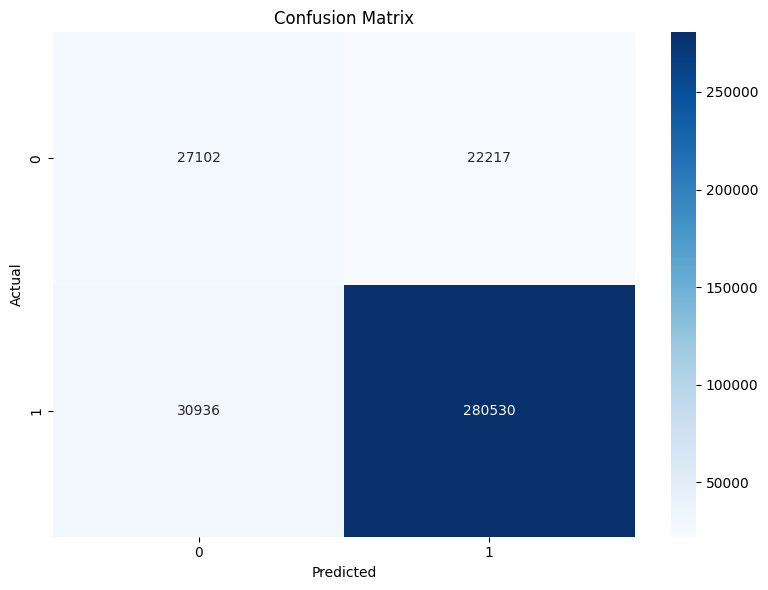

In [56]:
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the saved model
model = joblib.load('distilled_logistic_regression_model.joblib')

# 2. Make predictions on your test data
y_pred = model.predict(X_test)

# 3. Calculate metrics (assuming you have y_test available)
# If you don't have y_test, you'll need that for evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# 4. Print metrics
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# 5. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto',
            yticklabels=model.classes_ if hasattr(model, 'classes_') else 'auto')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------- Step 1: Define the Model -----------
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 2)  # Binary classification output
        )

    def forward(self, x):
        return self.network(x)


# ----------- Step 2: Load Data (replace with your own if needed) -----------

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert class 1 (Benign) to 0, and everything else to 1 (Malign)
y_train_np = (y_train_np != 1).astype(int)
y_test_np = (y_test_np != 1).astype(int)


# ----------- Step 3: Convert to Torch Tensors -----------
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np.to_numpy(), dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np.to_numpy(), dtype=torch.long)

# ----------- Step 4: Initialize Model, Loss, Optimizer -----------
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ----------- Step 5: Training -----------
start_train = time.time()

epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

end_train = time.time()
print(f"✅ Training Time: {end_train - start_train:.4f} seconds")

# ----------- Step 6: Inference -----------
model.eval()
with torch.no_grad():
    start_infer = time.time()
    outputs = model(X_test)
    predicted = torch.argmax(outputs, dim=1)
    end_infer = time.time()

print(f"✅ Inference Time on {len(X_test)} samples: {end_infer - start_infer:.4f} seconds")

# ----------- Step 7: Optional Accuracy ----------
accuracy = (predicted == y_test).float().mean()
print(f"✅ Accuracy: {accuracy.item() * 100:.2f}%")


✅ Training Time: 52.2554 seconds
✅ Inference Time on 288628 samples: 0.3412 seconds
✅ Accuracy: 100.00%


Step 1: Loading dataset...
Dataset loaded: 1154509 training samples, 288628 test samples

Step 2: Initializing models...

Step 3: Training teacher model...
Training the teacher model...
Epoch 1/10, Loss: 0.2725
Epoch 2/10, Loss: 0.2597
Epoch 3/10, Loss: 0.2569
Epoch 4/10, Loss: 0.2558
Epoch 5/10, Loss: 0.2549
Epoch 6/10, Loss: 0.2543
Epoch 7/10, Loss: 0.2536
Epoch 8/10, Loss: 0.2529
Epoch 9/10, Loss: 0.2526
Epoch 10/10, Loss: 0.2525
Teacher training completed in 509.3732 seconds

Step 4: Generating soft labels from teacher...
Generating soft labels with temperature 3.0...

Step 5: Training student models with knowledge distillation...
Training student with knowledge distillation (alpha=0.5, temperature=3.0)...
Epoch 1/10, Loss: 44.6469
Epoch 2/10, Loss: 69.3593
Epoch 3/10, Loss: 60.4952
Epoch 4/10, Loss: 1.9873
Epoch 5/10, Loss: 15.5920
Epoch 6/10, Loss: 364.3932
Epoch 7/10, Loss: 23.7194
Epoch 8/10, Loss: 5338.3531
Epoch 9/10, Loss: 0.1460
Epoch 10/10, Loss: 0.1372
Student training co

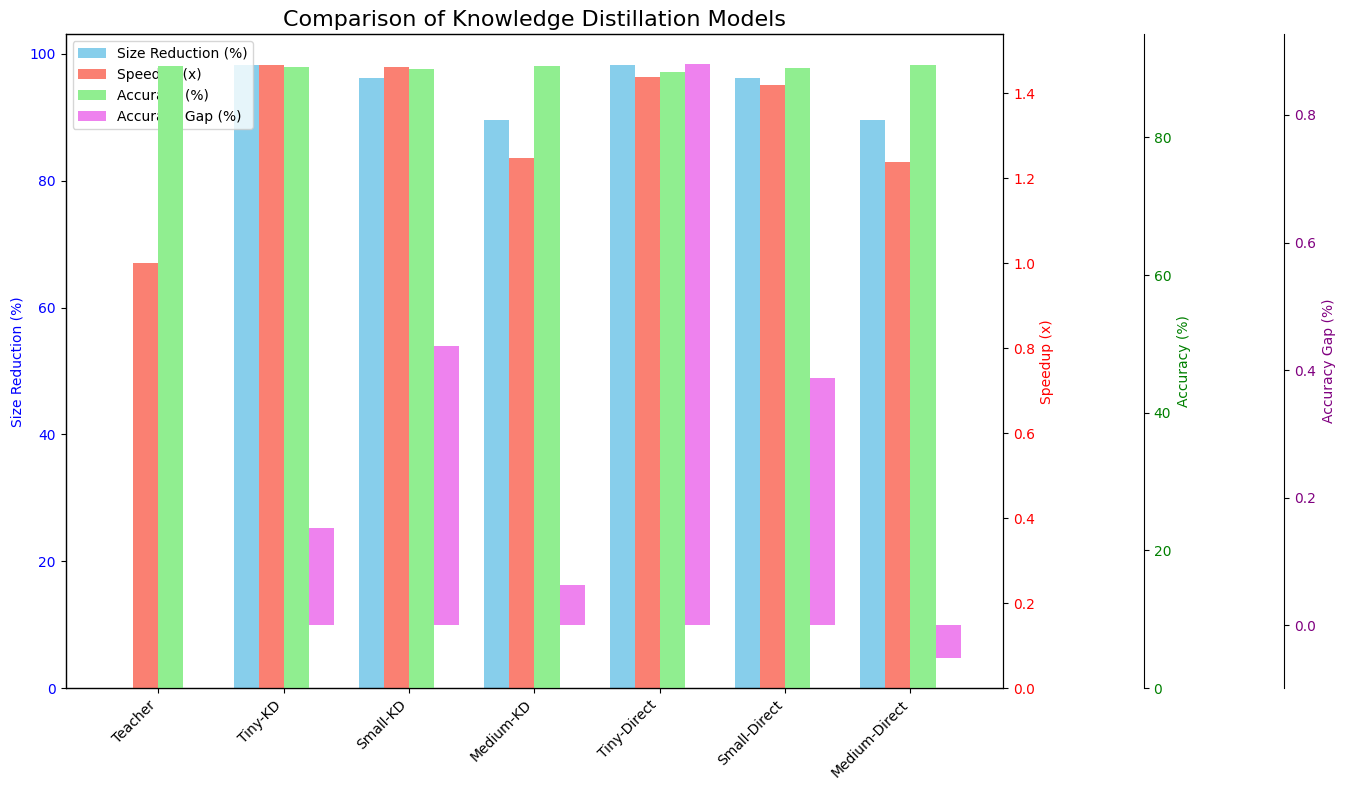

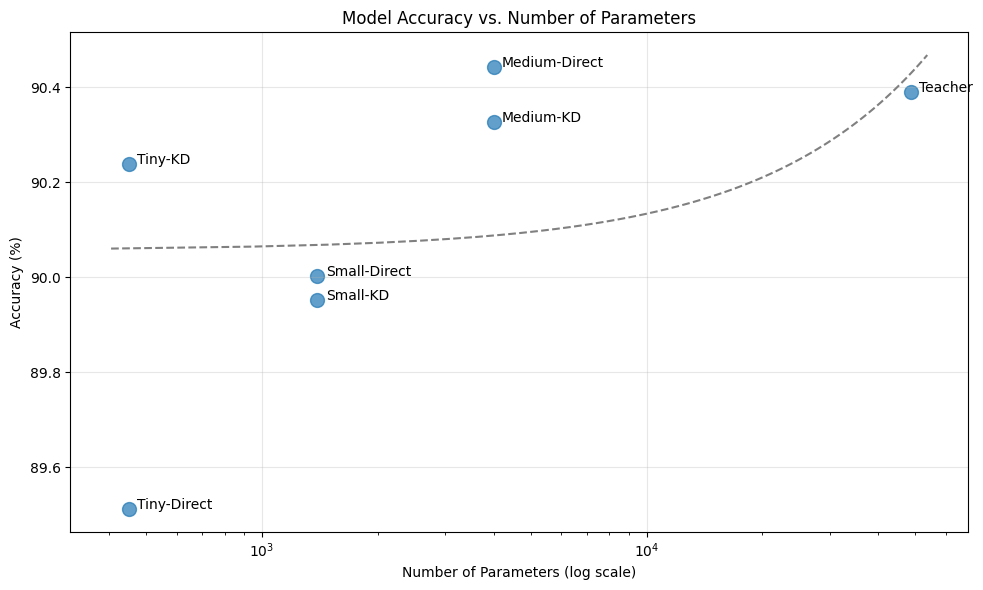

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------- Step 1: Define Teacher and Student Models -----------
class TeacherNN(nn.Module):
    def __init__(self, input_size):
        super(TeacherNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)  # Binary classification output
        )
    def forward(self, x):
        return self.network(x)

# Define different student models with varying complexity
class TinyStudentNN(nn.Module):
    def __init__(self, input_size):
        super(TinyStudentNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.network(x)

class SmallStudentNN(nn.Module):
    def __init__(self, input_size):
        super(SmallStudentNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.network(x)

class MediumStudentNN(nn.Module):
    def __init__(self, input_size):
        super(MediumStudentNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.network(x)

# ----------- Step 2: Generate or Load Data -----------
def load_dataset(n_samples=10000, n_features=20):
    
    
    # Split data
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to torch tensors
    X_train = torch.tensor(X_train_np.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train_np.to_numpy(), dtype=torch.long)
    X_test = torch.tensor(X_test_np.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test_np.to_numpy(), dtype=torch.long)  
    
    return X_train, y_train, X_test, y_test

# ----------- Step 3: Train Teacher Model -----------
def train_teacher(model, X_train, y_train, epochs=10, batch_size=64):
    print("Training the teacher model...")
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    start_train = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    end_train = time.time()
    train_time = end_train - start_train
    print(f"Teacher training completed in {train_time:.4f} seconds")
    
    return model, train_time

# ----------- Step 4: Generate Soft Labels from Teacher -----------
def generate_soft_labels(teacher_model, X_train, X_test, temperature=3.0):
    print(f"Generating soft labels with temperature {temperature}...")
    teacher_model.eval()
    
    # Apply temperature scaling to teacher outputs
    with torch.no_grad():
        # Generate soft labels for training data
        logits_train = teacher_model(X_train)
        soft_train = nn.functional.softmax(logits_train / temperature, dim=1)
        
        # Generate soft labels for test data (for evaluation)
        logits_test = teacher_model(X_test)
        soft_test = nn.functional.softmax(logits_test / temperature, dim=1)
    
    return soft_train, soft_test

# ----------- Step 5: Train Student with Knowledge Distillation -----------
def train_student_kd(student_model, X_train, soft_labels, y_train, epochs=10, batch_size=64, 
                    alpha=0.5, temperature=3.0):
    print(f"Training student with knowledge distillation (alpha={alpha}, temperature={temperature})...")
    
    train_dataset = torch.utils.data.TensorDataset(X_train, soft_labels, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define distillation loss and optimizer
    ce_criterion = nn.CrossEntropyLoss()
    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters(), lr=0.01)
    
    start_train = time.time()
    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0
        
        for inputs, soft_targets, hard_targets in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            student_logits = student_model(inputs)
            
            # Apply temperature scaling for KL divergence loss
            student_logits_temp = student_logits / temperature
            
            # Calculate losses
            # Hard loss - cross entropy with true labels
            hard_loss = ce_criterion(student_logits, hard_targets)
            
            # Soft loss - KL divergence with teacher's soft predictions
            soft_loss = kl_criterion(
                nn.functional.log_softmax(student_logits_temp, dim=1),
                soft_targets
            ) * (temperature**2)  # Scale by temperature squared
            
            # Combined loss
            loss = alpha * soft_loss + (1 - alpha) * hard_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    end_train = time.time()
    train_time = end_train - start_train
    print(f"Student training completed in {train_time:.4f} seconds")
    
    return student_model, train_time
    
# ----------- Step 6: Train Student Directly -----------
def train_student_direct(student_model, X_train, y_train, epochs=10, batch_size=64):
    print("Training student directly (without distillation)...")
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student_model.parameters(), lr=0.01)
    
    start_train = time.time()
    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = student_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    end_train = time.time()
    train_time = end_train - start_train
    print(f"Direct student training completed in {train_time:.4f} seconds")
    
    return student_model, train_time

# ----------- Step 7: Model Evaluation Function -----------
def evaluate_model(model, X_test, y_test, batch_size=64):
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    model.eval()
    correct = 0
    total = 0
    
    start_infer = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end_infer = time.time()
    
    inference_time = end_infer - start_infer
    accuracy = correct / total
    
    return accuracy, inference_time

# ----------- Step 8: Model Size Calculation -----------
def get_model_size(model, filename="model.pt"):
    torch.save(model.state_dict(), filename)
    size_bytes = os.path.getsize(filename)
    size_mb = size_bytes / (1024 * 1024)
    os.remove(filename)
    return size_mb

# ----------- Step 9: Compare All Models -----------
def compare_models(models_dict, X_test, y_test):
    results = []
    
    for name, model in models_dict.items():
        print(f"\nEvaluating {name} model...")
        
        # Measure size
        size_mb = get_model_size(model)
        
        # Measure accuracy and inference time
        accuracy, inference_time = evaluate_model(model, X_test, y_test)
        
        # Get parameter count
        param_count = sum(p.numel() for p in model.parameters())
        
        # Store results
        results.append({
            "Model": name,
            "Size (MB)": size_mb,
            "Parameters": param_count,
            "Accuracy": accuracy * 100,
            "Inference Time (s)": inference_time,
            "Size Reduction (%)": 0,  # Will be calculated later
            "Speedup": 0,  # Will be calculated later
            "Accuracy Gap (%)": 0  # Will be calculated later
        })
    
    # Create DataFrame and calculate relative metrics
    results_df = pd.DataFrame(results)
    baseline_size = results_df.loc[results_df["Model"] == "Teacher", "Size (MB)"].values[0]
    baseline_time = results_df.loc[results_df["Model"] == "Teacher", "Inference Time (s)"].values[0]
    baseline_acc = results_df.loc[results_df["Model"] == "Teacher", "Accuracy"].values[0]
    
    results_df["Size Reduction (%)"] = (1 - results_df["Size (MB)"] / baseline_size) * 100
    results_df["Speedup"] = baseline_time / results_df["Inference Time (s)"]
    results_df["Accuracy Gap (%)"] = baseline_acc - results_df["Accuracy"]
    
    # Fix potential division by zero
    results_df["Speedup"] = results_df["Speedup"].replace([np.inf, -np.inf], 0)
    
    return results_df

# ----------- Step 10: Visualization Functions -----------
def plot_comparison(results_df):
    # Set up the figure
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # X-axis positions
    x = np.arange(len(results_df))
    width = 0.2
    
    # Plot size reduction
    ax1.bar(x - width*1.5, results_df["Size Reduction (%)"], width, label="Size Reduction (%)", color="skyblue")
    ax1.set_ylabel("Size Reduction (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    
    # Create a second y-axis for speedup
    ax2 = ax1.twinx()
    ax2.bar(x - width/2, results_df["Speedup"], width, label="Speedup (x)", color="salmon")
    ax2.set_ylabel("Speedup (x)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    
    # Create a third y-axis for accuracy
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.15))
    ax3.bar(x + width/2, results_df["Accuracy"], width, label="Accuracy (%)", color="lightgreen")
    ax3.set_ylabel("Accuracy (%)", color="green")
    ax3.tick_params(axis="y", labelcolor="green")
    
    # Create a fourth y-axis for accuracy gap
    ax4 = ax1.twinx()
    ax4.spines["right"].set_position(("axes", 1.3))
    ax4.bar(x + width*1.5, results_df["Accuracy Gap (%)"], width, label="Accuracy Gap (%)", color="violet")
    ax4.set_ylabel("Accuracy Gap (%)", color="purple")
    ax4.tick_params(axis="y", labelcolor="purple")
    
    # Set x-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(results_df["Model"])
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    
    # Add title and legend
    ax1.set_title("Comparison of Knowledge Distillation Models", fontsize=16)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3 + lines4, labels1 + labels2 + labels3 + labels4, loc="upper left", fontsize=10)
    
    plt.tight_layout()
    plt.savefig("distillation_comparison.png")
    print("Visualization saved as 'distillation_comparison.png'")
    
    return fig

def plot_params_vs_accuracy(results_df):
    plt.figure(figsize=(10, 6))
    
    # Plot scatter points
    plt.scatter(results_df["Parameters"], results_df["Accuracy"], s=100, alpha=0.7)
    
    # Label each point
    for i, row in results_df.iterrows():
        plt.annotate(row["Model"], 
                     (row["Parameters"]*1.05, row["Accuracy"]),
                     fontsize=10)
    
    # Add trend line
    z = np.polyfit(results_df["Parameters"], results_df["Accuracy"], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results_df["Parameters"].min()*0.9, results_df["Parameters"].max()*1.1, 100)
    plt.plot(x_trend, p(x_trend), '--', color='gray')
    
    # Add labels and title
    plt.xscale('log')  # Use log scale for parameters
    plt.xlabel('Number of Parameters (log scale)')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy vs. Number of Parameters')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("params_vs_accuracy.png")
    print("Parameters vs. Accuracy plot saved as 'params_vs_accuracy.png'")
    
    return plt.gcf()

# Add a main function to run the entire pipeline
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Parameters
    input_size = X.shape[1]  # Get input size from your existing data
    epochs = 10
    batch_size = 64
    temperature = 3.0
    alpha = 0.5
    
    # Step 1: Load and preprocess dataset
    print("Step 1: Loading dataset...")
    X_train, y_train, X_test, y_test = load_dataset()
    print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")
    
    # Step 2: Initialize models
    print("\nStep 2: Initializing models...")
    teacher_model = TeacherNN(input_size)
    tiny_student = TinyStudentNN(input_size)
    small_student = SmallStudentNN(input_size)
    medium_student = MediumStudentNN(input_size)
    
    # Step 3: Train teacher model
    print("\nStep 3: Training teacher model...")
    teacher_model, teacher_train_time = train_teacher(teacher_model, X_train, y_train, epochs, batch_size)
    
    # Step 4: Generate soft labels
    print("\nStep 4: Generating soft labels from teacher...")
    soft_train, soft_test = generate_soft_labels(teacher_model, X_train, X_test, temperature)
    
    # Step 5: Train students with knowledge distillation
    print("\nStep 5: Training student models with knowledge distillation...")
    tiny_student_kd, tiny_kd_time = train_student_kd(
        tiny_student, X_train, soft_train, y_train, epochs, batch_size, alpha, temperature
    )
    
    small_student_kd, small_kd_time = train_student_kd(
        small_student, X_train, soft_train, y_train, epochs, batch_size, alpha, temperature
    )
    
    medium_student_kd, medium_kd_time = train_student_kd(
        medium_student, X_train, soft_train, y_train, epochs, batch_size, alpha, temperature
    )
    
    # Step 6: Train students directly (for comparison)
    print("\nStep 6: Training student models directly (without distillation)...")
    tiny_student_direct = TinyStudentNN(input_size)
    tiny_student_direct, tiny_direct_time = train_student_direct(
        tiny_student_direct, X_train, y_train, epochs, batch_size
    )
    
    small_student_direct = SmallStudentNN(input_size)
    small_student_direct, small_direct_time = train_student_direct(
        small_student_direct, X_train, y_train, epochs, batch_size
    )
    
    medium_student_direct = MediumStudentNN(input_size)
    medium_student_direct, medium_direct_time = train_student_direct(
        medium_student_direct, X_train, y_train, epochs, batch_size
    )
    
    # Step 7: Compare all models
    print("\nStep 7: Comparing all models...")
    models_dict = {
        "Teacher": teacher_model,
        "Tiny-KD": tiny_student_kd,
        "Small-KD": small_student_kd,
        "Medium-KD": medium_student_kd,
        "Tiny-Direct": tiny_student_direct,
        "Small-Direct": small_student_direct,
        "Medium-Direct": medium_student_direct
    }
    
    results_df = compare_models(models_dict, X_test, y_test)
    print("\nResults Summary:")
    print(results_df.to_string(index=False))
    
    # Step 8: Visualize results
    print("\nStep 8: Visualizing results...")
    plot_comparison(results_df)
    plot_params_vs_accuracy(results_df)
    
    # Save results to CSV
    results_df.to_csv("distillation_results.csv", index=False)
    print("Results saved to 'distillation_results.csv'")

if __name__ == "__main__":
    main()

In [46]:
X_test_10x = np.concatenate([X_test] * 10, axis=0)

In [47]:
# Measure inference time


inference_start = time.time()
y_pred = xgb_model_improved.predict(X_test_10x)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")


Inference time: 0.1943 seconds


In [68]:
# Function to dequantize int8 values for prediction
def dequantize_from_int8(arr, scale_factor):
    """Convert int8 array back to floating point with scaling"""
    return arr.astype(np.float32) / scale_factor

# Create a prediction function for int8 model
def predict_with_int8_model(model, scaling_factors, X):
    """Make predictions with the int8 quantized model"""
    # Create a copy of the model for inference
    inference_model = GaussianNB()
    
    # Copy attributes from int8 model
    inference_model.classes_ = model.classes_
    inference_model.n_features_in_ = model.n_features_in_
    inference_model.epsilon_ = model.epsilon_  # This won't affect predictions much
    
    # Dequantize the parameters
    inference_model.theta_ = dequantize_from_int8(model.theta_, scaling_factors['theta'])
    inference_model.var_ = dequantize_from_int8(model.var_, scaling_factors['var'])
    inference_model.class_prior_ = dequantize_from_int8(model.class_prior_, scaling_factors['prior'])
    
    # Make predictions
    return inference_model.predict(X)

# Load the int8 model and scaling factors
with open(int8_filename, 'rb') as f:
    int8_model, scaling_factors = pickle.load(f)

# Evaluate int8 model prediction time
start_time = time.time()
y_pred_int8 = predict_with_int8_model(int8_model, scaling_factors, X_test)
end_time = time.time()
int8_inference_time = end_time - start_time
int8_accuracy = accuracy_score(y_test, y_pred_int8)

print("\n--- Int8 Model Prediction Performance ---")
print(f"Int8 model inference time: {int8_inference_time:.4f} seconds")
print(f"Speed comparison to original: {original_inference_time / int8_inference_time:.2f}x")
print(f"Int8 model accuracy: {int8_accuracy:.4f}")
print(f"Accuracy difference from original: {(int8_accuracy - original_accuracy) * 100:.4f}%")

# Compare all models
print("\n--- Comparison Summary ---")
models = ["Original", "Float32", "Float16", "Int8"]
sizes = [original_size, quantized_size, extreme_quantized_size, int8_size]
times = [original_inference_time, quantized_inference_time, extreme_inference_time, int8_inference_time]
accuracies = [original_accuracy, quantized_accuracy, extreme_accuracy, int8_accuracy]

print(f"{'Model':10} | {'Size (KB)':10} | {'Time (s)':10} | {'Accuracy':10} | {'Size Ratio':10} | {'Speed Ratio':10}")
print("-" * 75)

for i, model in enumerate(models):
    size_ratio = sizes[0] / sizes[i]
    speed_ratio = times[0] / times[i]
    print(f"{model:10} | {sizes[i]/1024:10.2f} | {times[i]:10.4f} | {accuracies[i]:10.4f} | {size_ratio:10.2f}x | {speed_ratio:10.2f}x")


--- Int8 Model Prediction Performance ---
Int8 model inference time: 0.0575 seconds
Speed comparison to original: 1.30x
Int8 model accuracy: 0.0027
Accuracy difference from original: -22.1475%

--- Comparison Summary ---
Model      | Size (KB)  | Time (s)   | Accuracy   | Size Ratio | Speed Ratio
---------------------------------------------------------------------------
Original   |       1.23 |     0.0747 |     0.2242 |       1.00x |       1.00x
Float32    |       0.96 |     0.0561 |     0.2242 |       1.29x |       1.33x
Float16    |       0.80 |     0.0559 |     0.0027 |       1.53x |       1.34x
Int8       |       0.77 |     0.0575 |     0.0027 |       1.60x |       1.30x


Training teacher model (XGBoost)...
Generating soft labels from teacher model...

Training student model (Simple Neural Network) with knowledge distillation...
Epoch 10/100, Loss: -0.3695
Epoch 20/100, Loss: -0.3766
Epoch 30/100, Loss: -0.3785
Epoch 40/100, Loss: -0.3796
Epoch 50/100, Loss: -0.3804
Epoch 60/100, Loss: -0.3812
Epoch 70/100, Loss: -0.3818
Epoch 80/100, Loss: -0.3823
Epoch 90/100, Loss: -0.3827
Epoch 100/100, Loss: -0.3830
Student model training completed in 7.83 seconds

Comparing model sizes...

Evaluating models...

Training neural network directly on original labels for comparison...
Direct Training - Epoch 10/100, Loss: 0.2341
Direct Training - Epoch 20/100, Loss: 0.1852
Direct Training - Epoch 30/100, Loss: 0.1650
Direct Training - Epoch 40/100, Loss: 0.1515
Direct Training - Epoch 50/100, Loss: 0.1412
Direct Training - Epoch 60/100, Loss: 0.1339
Direct Training - Epoch 70/100, Loss: 0.1270
Direct Training - Epoch 80/100, Loss: 0.1221
Direct Training - Epoch 90/100,

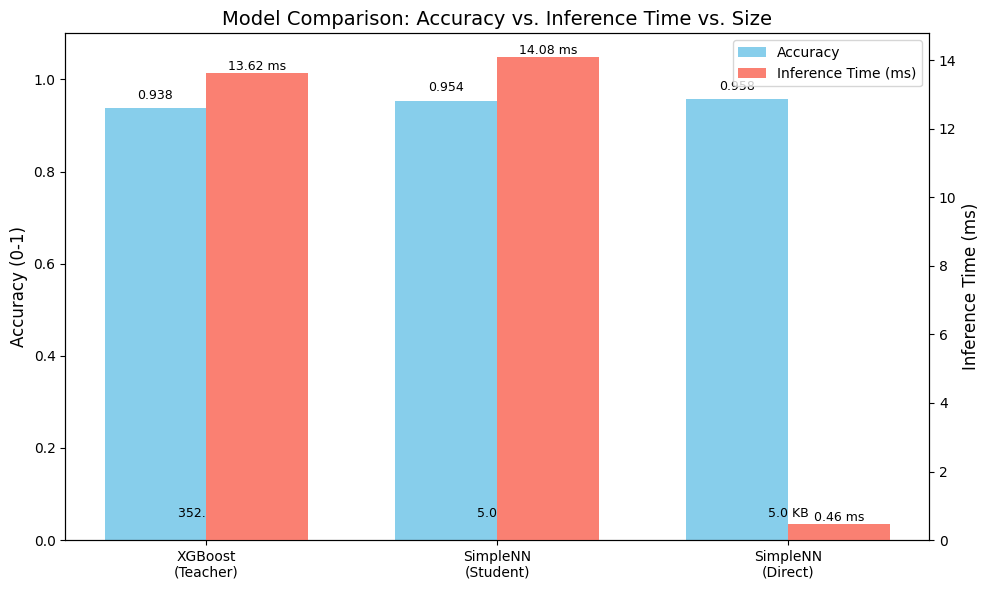

In [29]:
import numpy as np
import pandas as pd
import time
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Train the teacher model (XGBoost)
print("Training teacher model (XGBoost)...")
teacher_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42
)
teacher_model.fit(X_train_scaled, y_train)

# 2. Generate soft labels from teacher model
print("Generating soft labels from teacher model...")
teacher_probs = teacher_model.predict_proba(X_train_scaled)
teacher_preds_test = teacher_model.predict(X_test_scaled)
teacher_probs_test = teacher_model.predict_proba(X_test_scaled)

# 3. Define a simple neural network student model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # A very simple network with just one hidden layer
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),  # Small hidden layer
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer (2 classes)
        )
        
    def forward(self, x):
        return torch.softmax(self.network(x), dim=1)

# 4. Knowledge distillation function with temperature scaling
def distill_knowledge(teacher_probs, X_train, X_test, temperature=2.0, epochs=100):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    teacher_probs_tensor = torch.FloatTensor(teacher_probs)
    X_test_tensor = torch.FloatTensor(X_test)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, teacher_probs_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    # Initialize student model
    student_model = SimpleNN(X_train.shape[1])
    
    # Define loss function and optimizer
    # KL divergence loss is great for distillation as it measures difference between probability distributions
    criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    
    # Training loop
    student_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, teacher_targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            student_outputs = student_model(inputs)
            
            # Apply temperature scaling for softer probabilities
            student_outputs_temp = torch.log(student_outputs) / temperature
            teacher_targets_temp = teacher_targets / temperature
            
            # Calculate loss
            loss = criterion(student_outputs_temp, teacher_targets_temp)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        # Print progress every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')
    
    return student_model, X_test_tensor

# 5. Train the student model
print("\nTraining student model (Simple Neural Network) with knowledge distillation...")
start_train_time = time.time()
student_model, X_test_tensor = distill_knowledge(teacher_probs, X_train_scaled, X_test_scaled)
student_train_time = time.time() - start_train_time
print(f"Student model training completed in {student_train_time:.2f} seconds")

# 6. Define a function to measure inference time and accuracy
def evaluate_model(model_name, model, X_test, X_test_tensor, y_test):
    if model_name == 'XGBoost':
        start_time = time.time()
        predictions = model.predict(X_test)
        probs = model.predict_proba(X_test)
        inference_time = time.time() - start_time
    else:  # Neural Network
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            probs = model(X_test_tensor).numpy()
            predictions = np.argmax(probs, axis=1)
            inference_time = time.time() - start_time
    
    acc = accuracy_score(y_test, predictions)
    loss = log_loss(y_test, probs)
    
    return acc, loss, inference_time

# 7. Measure model sizes
print("\nComparing model sizes...")

# Save models to disk
pickle.dump(teacher_model, open("teacher_model.pkl", "wb"))
torch.save(student_model.state_dict(), "student_model.pt")

teacher_size = os.path.getsize("teacher_model.pkl") / 1024  # KB
student_size = os.path.getsize("student_model.pt") / 1024  # KB

# Clean up
os.remove("teacher_model.pkl")
os.remove("student_model.pt")

# 8. Evaluate both models
print("\nEvaluating models...")
teacher_acc, teacher_loss, teacher_time = evaluate_model('XGBoost', teacher_model, X_test_scaled, None, y_test)
student_acc, student_loss, student_time = evaluate_model('NN', student_model, None, X_test_tensor, y_test)

# 9. Train a neural network directly on original labels for comparison
print("\nTraining neural network directly on original labels for comparison...")
direct_model = SimpleNN(X_train_scaled.shape[1])
y_train_tensor = torch.LongTensor(y_train)
direct_criterion = nn.CrossEntropyLoss()
direct_optimizer = optim.Adam(direct_model.parameters(), lr=0.001)

# Create dataset and dataloader
direct_train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), y_train_tensor)
direct_train_loader = DataLoader(direct_train_dataset, batch_size=128, shuffle=True)

# Training loop
direct_model.train()
for epoch in range(100):
    running_loss = 0.0
    for inputs, targets in direct_train_loader:
        direct_optimizer.zero_grad()
        outputs = direct_model(inputs)
        loss = direct_criterion(torch.log(outputs), targets)
        loss.backward()
        direct_optimizer.step()
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Direct Training - Epoch {epoch+1}/100, Loss: {running_loss/len(direct_train_loader):.4f}')

# Evaluate direct model
direct_acc, direct_loss, direct_time = evaluate_model('NN', direct_model, None, X_test_tensor, y_test)

# 10. Print results
print("\nModel Performance Comparison:")
print("-" * 90)
print(f"{'Model':<25} {'Accuracy':<10} {'Log Loss':<10} {'Inference Time (s)':<20} {'Size (KB)':<10}")
print("-" * 90)
print(f"{'XGBoost (Teacher)':<25} {teacher_acc:.4f} {teacher_loss:.4f} {teacher_time:.6f} {teacher_size:.2f}")
print(f"{'SimpleNN (Student)':<25} {student_acc:.4f} {student_loss:.4f} {student_time:.6f} {student_size:.2f}")
print(f"{'SimpleNN (Direct)':<25} {direct_acc:.4f} {direct_loss:.4f} {direct_time:.6f} {student_size:.2f}")
print("-" * 90)

# Size and speed comparisons
size_reduction_percent = (1 - student_size / teacher_size) * 100
speed_improvement_percent = (1 - student_time / teacher_time) * 100
accuracy_gap = (teacher_acc - student_acc) * 100
accuracy_gain = (student_acc - direct_acc) * 100

print(f"\nSize reduction: {size_reduction_percent:.2f}% (Student is {teacher_size/student_size:.1f}x smaller)")
print(f"Speed improvement: {speed_improvement_percent:.2f}% (Student is {teacher_time/student_time:.1f}x faster)")
print(f"Accuracy gap from teacher: {accuracy_gap:.2f}% (was 13% with Naive Bayes)")
print(f"Accuracy gain over direct training: {accuracy_gain:.2f}%")

# 11. Visualize trade-offs
try:
    import matplotlib.pyplot as plt
    
    models = ['XGBoost\n(Teacher)', 'SimpleNN\n(Student)', 'SimpleNN\n(Direct)']
    accuracies = [teacher_acc, student_acc, direct_acc]
    inference_times = [teacher_time * 1000, student_time * 1000, direct_time * 1000]  # Convert to ms
    sizes = [teacher_size, student_size, student_size]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    ax1.set_ylabel('Accuracy (0-1)', fontsize=12)
    ax1.set_ylim(0, 1.1)
    
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, inference_times, width, label='Inference Time (ms)', color='salmon')
    ax2.set_ylabel('Inference Time (ms)', fontsize=12)
    
    # Add size annotations
    for i, (acc, time, size) in enumerate(zip(accuracies, inference_times, sizes)):
        ax1.annotate(f'{acc:.3f}', xy=(i - width/2, acc + 0.02), ha='center', fontsize=9)
        ax2.annotate(f'{time:.2f} ms', xy=(i + width/2, time + 0.1), ha='center', fontsize=9)
        ax1.annotate(f'{size:.1f} KB', xy=(i, 0.05), ha='center', fontsize=9)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_title('Model Comparison: Accuracy vs. Inference Time vs. Size', fontsize=14)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    print("\nPlot saved as 'model_comparison.png'")
except ImportError:
    print("\nMatplotlib not installed. Skipping visualization.")

In [49]:
inference_start = time.time()
y_pred = nb_model.predict(X_test_10x)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")

Inference time: 0.7702 seconds


In [50]:
X_train=X_train[:357000]
y_train=y_train[:357000]
print(len(X_train))
print(len(X_test))

357000
360785


In [52]:
xgb_model_improved = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='aucpr',  # Performance metric
    n_estimators=1,  # Equivalent to "epochs" (number of boosting rounds)
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    reg_lambda=1,
    scale_pos_weight=0.3,
    subsample=0.9,
    colsample_bytree=0.5
)

start_time = time.time()

xgb_model_improved.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  
    verbose=True
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")

[0]	validation_0-aucpr:0.47624
Training time: 0.2084 seconds


In [54]:
# Measure inference time


inference_start = time.time()
y_pred = xgb_model_improved.predict(X_test)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")


Inference time: 0.0455 seconds


In [56]:




# Define Naïve Bayes model
nb_model = GaussianNB(var_smoothing=1e-9)

# Measure training time
start_time = time.time()
nb_model.fit(X_train, y_train)
end_time = time.time()

# Compute training duration
training_time = end_time - start_time

# Make predictions



# Print results
print(f"Training Time: {training_time:.4f} seconds")


Training Time: 0.0441 seconds


In [59]:
inference_start = time.time()
y_pred = nb_model.predict(X_test)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")

Inference time: 0.0608 seconds


In [60]:
X_train=X_train[:35000]
y_train=y_train[:35000]
X_test=X_test[:35000]
y_test=y_test[:35000]
print(len(X_test))

35000


In [61]:
len(X_train)

35000

In [62]:
# optimal_params.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)],verbose = False)

In [63]:
import time

In [65]:

xgb_model_improved = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='aucpr',  # Performance metric
    n_estimators=1,  # Equivalent to "epochs" (number of boosting rounds)
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    reg_lambda=1,
    scale_pos_weight=0.3,
    subsample=0.9,
    colsample_bytree=0.5
)

start_time = time.time()

xgb_model_improved.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  
    verbose=True
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.4f} seconds")

[0]	validation_0-aucpr:0.47119
Training time: 0.0500 seconds


In [68]:
# Measure inference time


inference_start = time.time()
y_pred = xgb_model_improved.predict(X_test)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")


Inference time: 0.0167 seconds


In [72]:
from sklearn.naive_bayes import GaussianNB




# Define Naïve Bayes model
nb_model = GaussianNB(var_smoothing=1e-9)

# Measure training time
start_time = time.time()
nb_model.fit(X_train, y_train)
end_time = time.time()

# Compute training duration
training_time = end_time - start_time

# Make predictions



# Print results
print(f"Training Time: {training_time:.4f} seconds")


Training Time: 0.0058 seconds


In [74]:
inference_start = time.time()
y_pred = nb_model.predict(X_test)
inference_end = time.time()

print(f"Inference time: {inference_end - inference_start:.4f} seconds")

Inference time: 0.0068 seconds
